<a href="https://colab.research.google.com/github/jaydent22/ics661-assignments/blob/main/hw3/661_HW3_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 for short joke generation

This noteboook involves fine-tuning a GPT-2 model to generate short jokes based on three beginning words.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast, TFGPT2LMHeadModel, create_optimizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import scipy.stats as stats
import re

In [2]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
len(tokenizer.get_vocab())

50257

## Preprocessing

In [5]:
df = pd.read_csv('data', header=0, names=['joke'])

In [6]:
df.head()

,joke
1,What did the bartender say to the jumper cable...
2,Don't you hate jokes about German sausage? The...
3,Two artists had an art contest... It ended in ...
4,Why did the chicken cross the playground? To g...
5,What gun do you use to hunt a moose? A moosecut!


In [7]:
print(df.iloc[48].joke)

What did the green grape say to the purple grape? - "Breathe, stupid!"


In [8]:
print(df.iloc[40].joke)

What is the medical term for owning too many dogs? [A Roverdose](http://i.imgur.com/BtyF5ys.jpg)


In [9]:
print(df.iloc[21].joke)

What did the number zero say to the number eight? "Nice belt."


In [10]:
def clean(text):
  text = re.sub('http\S+|www\S+|https\S+', '', text)
  text = text.replace('\n+', '\n').strip()
  text = text.replace('\s+', ' ').strip()
  text = text.replace('\t', ' ')
  text = text.replace('\r', ' ')
  text = re.sub('[^\w\s.!?()"\',-]', '', text)
  # text = re.sub(r'([.!?])', r' \1 ', text)
  return text

In [11]:
df['joke'] = df['joke'].apply(clean)
print(df.iloc[48].joke)
print(df.iloc[40].joke)
print(df.iloc[21].joke)

What did the green grape say to the purple grape? - "Breathe, stupid!"
What is the medical term for owning too many dogs? A Roverdose(
What did the number zero say to the number eight? "Nice belt."


In [12]:
def word_count(text):
  return len(text.split())

In [13]:
counts = [word_count(joke) for joke in df['joke']]
len(counts)

1622

In [14]:
def tokenize_data(data, tokenizer, max_length=max(counts)):
  return tokenizer(
      data.tolist(),
      add_special_tokens=True,
      max_length=max_length,
      padding='max_length',
      truncation=True,
      return_tensors='tf'
  )

In [15]:
print(df['joke'].tolist())

['What did the bartender say to the jumper cables? You better not try to start anything.', "Don't you hate jokes about German sausage? They're the wurst!", 'Two artists had an art contest... It ended in a draw', 'Why did the chicken cross the playground? To get to the other slide.', 'What gun do you use to hunt a moose? A moosecut!', 'If life gives you melons, you might have dyslexia.', 'Broken pencils... ...are pointless.', "What did one snowman say to the other snowman? 'Do you smell carrots?'", "How many hipsters does it take to change a lightbulb? It's a really obscure number. You've probably never heard of it.", 'Where do sick boats go? The dock!', 'I like my slaves like I like my coffee Free.', 'My girlfriend told me she was leaving me because I keep pretending to be a Transformer... I said, No, wait! I can change!', 'Old Chinese proverb Man who not shower in 7 days makes one reek.', 'What did the owner of a brownie factory say when his factory caught fire? "I\'m getting the fudg

In [16]:
tokenizer.encode("?")

[30]

In [17]:
print(df.iloc[21].joke)

What did the number zero say to the number eight? "Nice belt."


In [18]:
print(tokenizer.encode(df.iloc[21].joke))

[2061, 750, 262, 1271, 6632, 910, 284, 262, 1271, 3624, 30, 366, 35284, 10999, 526]


In [19]:
tokenizer.pad_token = tokenizer.eos_token
encodings = tokenize_data(df['joke'], tokenizer)
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [20]:
len(encodings['input_ids'])

1622

In [21]:
encodings['input_ids']

<tf.Tensor: shape=(1622, 40), dtype=int32, numpy=
array([[ 2061,   750,   262, ..., 50256, 50256, 50256],
       [ 3987,   470,   345, ..., 50256, 50256, 50256],
       [ 7571,  7912,   550, ..., 50256, 50256, 50256],
       ...,
       [    1, 25681,  1913, ..., 50256, 50256, 50256],
       [ 5195,   373,   262, ..., 50256, 50256, 50256],
       [ 2061,   318,  4334, ..., 50256, 50256, 50256]], dtype=int32)>

In [22]:
idx = np.random.randint(0, len(encodings['input_ids']))
print(df.iloc[idx].joke)
print(encodings['input_ids'][idx])
print(encodings['attention_mask'][idx])
print(tokenizer.decode(encodings['input_ids'][idx]))

What did the Buddhist say to the hotdog vendor? Make me one with everything.
tf.Tensor(
[ 2061   750   262 20838   910   284   262  3024  9703 18371    30  6889
   502   530   351  2279    13 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256], shape=(40,), dtype=int32)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0], shape=(40,), dtype=int32)
What did the Buddhist say to the hotdog vendor? Make me one with everything.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [23]:
train_data = encodings['input_ids'][:, :-1]
train_labels = encodings['input_ids'][:, 1:]

dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))

batch_size = 10
train_dataset = dataset.take(int(len(dataset) * 0.9))
val_dataset = dataset.skip(int(len(dataset) * 0.9))
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(39,), dtype=int32, numpy=
array([ 2061,   750,   262, 41118,   910,   284,   262, 31118, 18018,
          30,   921,  1365,   407,  1949,   284,   923,  1997,    13,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256], dtype=int32)>, <tf.Tensor: shape=(39,), dtype=int32, numpy=
array([  750,   262, 41118,   910,   284,   262, 31118, 18018,    30,
         921,  1365,   407,  1949,   284,   923,  1997,    13, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256], dtype=int32)>)


## GPT Model

In [24]:
model = TFGPT2LMHeadModel.from_pretrained('gpt2')
model.summary()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124439808 (474.70 MB)
Trainable params: 124439808 (474.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [26]:
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(train_dataset, epochs=4, validation_data=val_dataset)

Epoch 1/4
146/146 [==============================] - 48s 97ms/step - loss: 2.8377 - val_loss: 1.9419
Epoch 2/4
146/146 [==============================] - 11s 76ms/step - loss: 2.0111 - val_loss: 1.8734
Epoch 3/4
146/146 [==============================] - 11s 76ms/step - loss: 1.9327 - val_loss: 1.8368
Epoch 4/4
146/146 [==============================] - 11s 77ms/step - loss: 1.8783 - val_loss: 1.8125


Text(0.5, 0, 'epoch')

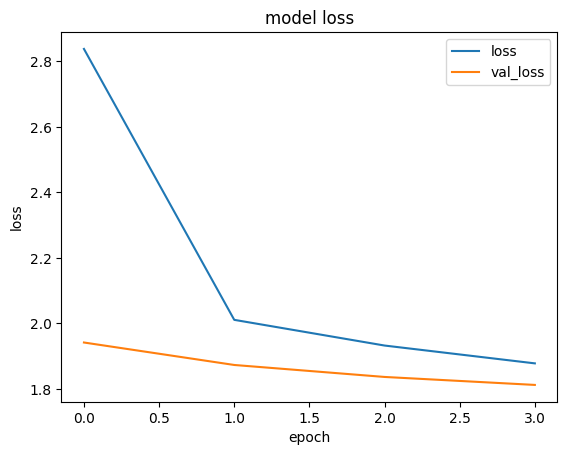

In [27]:
%matplotlib inline

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Joke generation

In [28]:
test_input = tokenizer.encode('Why did the', return_tensors='tf')
output = model.generate(
    test_input,
    max_length=40,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=False)
print(output)
# print(tokenizer.decode(output[0], skip_special_tokens=True))

tf.Tensor(
[[ 5195   750   262  3290   651   257 45548    30   679   373   257  1643
    286   257  3290    13 50256]], shape=(1, 17), dtype=int32)


In [29]:
print(tokenizer.decode(output[0]))

Why did the dog get a haircut? He was a bit of a dog.<|endoftext|>


## Predefined starting words

In [30]:
def generate_joke(prompt):
  input_ids = tokenizer.encode(prompt, return_tensors='tf')
  output = model.generate(
      input_ids,
      max_length=40,
      num_return_sequences=1,
      pad_token_id=tokenizer.eos_token_id,
      no_repeat_ngram_size=2,
      repetition_penalty=1.7,
      do_sample=True,
      temperature=0.9,
      top_k=10,
      top_p=0.9,
      # num_beams=15,
      # early_stopping=True
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)

In [31]:
prompt='Why did the'
joke = generate_joke(prompt)
print(joke)

Why did the dog say, "What do you call a cow that eats meat?"


In [32]:
# random sampling
prompt='What did the'
joke = generate_joke(prompt)
print(joke)

What did the old man say to his son when he was getting out of town? "Don't go into a restaurant."


## Random starting words

In [33]:
for i in range(3):
  print(f"Joke {i+1}:")
  prompt=' '.join(df['joke'].sample(1).values[0].split()[:3])
  print(f'Prompt: "{prompt}"')
  joke = generate_joke(prompt)
  print(joke)
  print()

Joke 1:
Prompt: "What did the"
What did the old man say to his girlfriend? "You're so beautiful"

Joke 2:
Prompt: "If the house"
If the house was full of chickens...
I had no idea what to do with it.

Joke 3:
Prompt: "Who makes the"
Who makes the most money? The man.



## Three random words

In [34]:
import requests

word_site = "https://www.mit.edu/~ecprice/wordlist.10000"

response = requests.get(word_site)
WORDS = response.content.splitlines()
WORDS = [word.decode('utf-8') for word in WORDS]

In [36]:
for i in range(3):
  print(f"Joke {i+1}:")
  prompt = ' '.join(np.random.choice(WORDS, 3))
  print(f'Prompt: "{prompt}"')
  joke = generate_joke(prompt)
  print(joke)
  print()

Joke 1:
Prompt: "shakira wealth outside"
shakira wealth outside Japan


Joke 2:
Prompt: "resistance stress institutions"
resistance stress institutions are the ones that will always get their way in a race against time. They've got to do better than them because they can't afford it, and so many other groups have

Joke 3:
Prompt: "compounds shorts witness"
compounds shorts witness a woman walk into the bar and ask for money, only to find out it was her husband.

